In [4]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px

In [5]:
from scipy import ndimage

In [32]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [16]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [17]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Dataset definition

In [6]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [7]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True)

In [8]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [9]:
import torchvision
from torchvision import datasets, models, transforms

In [10]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)

        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(
            in_features=2048, out_features=4, bias=True)

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
BATCH_SIZE = 12
EPOCHS = 300

In [13]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

### Overfitting on single batch of data

In [14]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [26]:
loss_func = torch.nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [17]:
train_data_single_batch = next(iter(train_dataloader))

In [18]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [19]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [20]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [21]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [22]:
output

tensor([[ 4.9836e-01,  1.7362e-03, -4.4777e-02, -3.4238e-02],
        [ 1.7809e+00, -4.8931e-01, -8.0218e-01,  3.0849e-01],
        [ 7.1995e-01, -6.6508e-02, -2.9676e-01, -8.8659e-03],
        [ 7.7081e-01, -7.0459e-02, -1.8574e-01,  4.4925e-02],
        [ 1.3689e+00, -2.6873e-01, -5.9175e-01,  1.2938e-01],
        [ 6.1959e-01, -7.7144e-02, -1.4679e-01, -2.9856e-02],
        [ 1.9468e+00, -4.8859e-01, -7.2039e-01,  2.7908e-01],
        [ 5.6102e-01, -5.3317e-02, -2.0053e-01,  7.6404e-03],
        [ 1.2809e+00, -3.6372e-01, -3.2486e-01,  1.2621e-01],
        [ 5.1718e-01, -4.5957e-02, -7.3289e-02, -3.0901e-02],
        [ 5.4521e-01, -2.9372e-02, -6.6410e-02, -4.2596e-03],
        [ 6.3708e-01, -8.7734e-02, -1.5244e-01, -2.9359e-02]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [23]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'],
                         train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[100.0000,  94.8000,  84.8000,  48.7000,  42.7000,  94.3000,  63.7000,
          69.8000, 110.0000,  58.4000, 128.0000, 117.0000],
        [246.0000, 244.0000, 319.0000, 150.0000, 192.0000, 327.0000, 265.0000,
         195.0000, 449.0000, 172.0000, 175.0000, 423.0000],
        [240.0000, 127.0000, 161.0000, 123.0000, 126.0000, 145.0000, 187.0000,
         133.0000, 154.0000, 136.0000,  88.2000, 146.0000],
        [  7.4000,   6.8000,   7.1000,   6.6000,   6.5000,   7.0000,   6.6000,
           6.8000,   7.2000,   6.7000,   6.9700,   7.2000]],
       dtype=torch.float64)

In [24]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)
stacked_gt

tensor([[100.0000, 246.0000, 240.0000,   7.4000],
        [ 94.8000, 244.0000, 127.0000,   6.8000],
        [ 84.8000, 319.0000, 161.0000,   7.1000],
        [ 48.7000, 150.0000, 123.0000,   6.6000],
        [ 42.7000, 192.0000, 126.0000,   6.5000],
        [ 94.3000, 327.0000, 145.0000,   7.0000],
        [ 63.7000, 265.0000, 187.0000,   6.6000],
        [ 69.8000, 195.0000, 133.0000,   6.8000],
        [110.0000, 449.0000, 154.0000,   7.2000],
        [ 58.4000, 172.0000, 136.0000,   6.7000],
        [128.0000, 175.0000,  88.2000,   6.9700],
        [117.0000, 423.0000, 146.0000,   7.2000]], device='cuda:0',
       dtype=torch.float64)

In [27]:
loss_func(output, stacked_gt)

tensor(2628.7049, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

In [28]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0, 1).to(device,
                                                                                                                                                                               dtype=torch.float)

model = ResNetCNN(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 27219.19921875, MSE: [7.8928228e+03 7.8077320e+04 2.2869018e+04 3.7620922e+01]
epoch: 10, loss: 4390.59423828125, MSE: [2.1459778e+03 1.2950723e+04 2.4602122e+03 5.4629955e+00]
epoch: 20, loss: 2818.145263671875, MSE: [1.5300024e+03 7.9472070e+03 1.7940079e+03 1.3637484e+00]
epoch: 30, loss: 961.9710693359375, MSE: [5.4982635e+02 9.9206915e+02 2.3050515e+03 9.3681908e-01]
epoch: 40, loss: 780.17578125, MSE: [3.9269189e+02 9.1254834e+02 1.8141152e+03 1.3475398e+00]
epoch: 50, loss: 626.7425537109375, MSE: [3.9781421e+02 7.4550830e+02 1.3629415e+03 7.0624429e-01]
epoch: 60, loss: 485.9268493652344, MSE: [4.0310416e+02 4.6288107e+02 1.0772404e+03 4.8192284e-01]
epoch: 70, loss: 411.3528747558594, MSE: [3.5937341e+02 1.9593547e+02 1.0897678e+03 3.3464959e-01]
epoch: 80, loss: 324.96417236328125, MSE: [3.5618515e+02 2.8977358e+01 9.1432037e+02 3.7366691e-01]
epoch: 90, loss: 275.562744140625, MSE: [3.5328464e+02 2.0342068e+01 7.2825629e+02 3.6798522e-01]
epoch: 100, loss: 19

### Training Definition

In [29]:
save_name = "checkpoint_state_dict_ResNet50_08_05_2022_KLDivLoss"

In [30]:
model_name = save_name+'.pth'

In [31]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [53]:
model = ResNetCNN(False).to(device)

In [54]:
wandb.watch(model, log="None", log_freq=20)

[]

In [51]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [52]:
loss_func = torch.nn.KLDivLoss(reduction='batchmean')

#### Find LR

In [46]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [47]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0, 1), dtype=torch.float))

In [48]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.59E-04


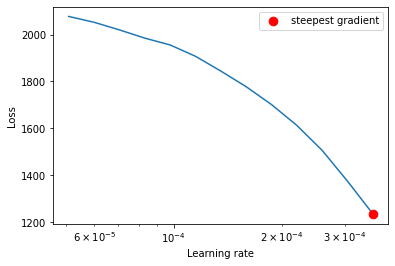

In [49]:
lr_finder.plot()
lr_finder.reset()

In [50]:
3.59E-04

0.000359

### Training

In [55]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [56]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [58]:
config = wandb.config
config.model = 'resnet50'
config.optimizer = 'AdamW'
config.loss_function = 'KLDiVLoss(reduction="mean")'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = 5
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResNet50 with KLDivLoss function'

In [59]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [60]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
            0, 1).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
                0, 1).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)

        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1],
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 2339.953125, train MSE: [5832.22021484375, 56175.66015625, 26839.05078125, 33.02310562133789]


epoch 0 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0, validation loss: 2340.01904296875, validation MSE: [5730.263671875, 54561.3984375, 26679.62890625, 34.52390670776367]
Validation loss decreased (inf --> 2340.019043).  Saving model ...


epoch 1 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 2339.48486328125, train MSE: [5837.9248046875, 56117.6640625, 26813.890625, 33.0292854309082]


epoch 1 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1, validation loss: 2331.55615234375, validation MSE: [5726.201171875, 54808.640625, 26919.466796875, 33.55018997192383]
Validation loss decreased (2340.019043 --> 2331.556152).  Saving model ...


epoch 2 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 2336.14501953125, train MSE: [5827.349609375, 55913.2421875, 26813.064453125, 33.01681900024414]


epoch 2 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2, validation loss: 2332.59423828125, validation MSE: [5635.43701171875, 54823.8046875, 26893.341796875, 34.183319091796875]
EarlyStopping counter: 1 out of 13


epoch 3 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 2339.063720703125, train MSE: [5832.4189453125, 56052.1640625, 26861.529296875, 33.02556610107422]


epoch 3 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3, validation loss: 2335.28564453125, validation MSE: [5693.86474609375, 54967.68359375, 26898.341796875, 33.95951843261719]
EarlyStopping counter: 2 out of 13


epoch 4 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 2337.4189453125, train MSE: [5825.54296875, 55937.54296875, 26837.521484375, 33.03415298461914]


epoch 4 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4, validation loss: 2343.952392578125, validation MSE: [5654.736328125, 54570.1953125, 26945.935546875, 34.520851135253906]
EarlyStopping counter: 3 out of 13


epoch 5 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 2341.310546875, train MSE: [5835.39794921875, 56201.78125, 26871.8671875, 33.03913497924805]


epoch 5 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 5, validation loss: 2338.276611328125, validation MSE: [5641.94189453125, 54587.44921875, 27130.953125, 34.18840789794922]
EarlyStopping counter: 4 out of 13


epoch 6 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 2341.68798828125, train MSE: [5846.41552734375, 56233.90234375, 26824.7109375, 33.07370376586914]


epoch 6 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 6, validation loss: 2331.67431640625, validation MSE: [5577.01904296875, 54414.953125, 26917.740234375, 34.22304153442383]
EarlyStopping counter: 5 out of 13


epoch 7 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 2335.257080078125, train MSE: [5824.1513671875, 55813.9453125, 26800.400390625, 33.03722381591797]


epoch 7 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 7, validation loss: 2341.098388671875, validation MSE: [5689.74462890625, 54782.703125, 26941.634765625, 34.22589874267578]
EarlyStopping counter: 6 out of 13


epoch 8 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 8, LR: 0.006, train loss: 2340.2177734375, train MSE: [5834.75, 56210.84765625, 26826.0078125, 33.01309585571289]


epoch 8 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 8, validation loss: 2343.905517578125, validation MSE: [5648.927734375, 54667.26953125, 26965.833984375, 34.484527587890625]
EarlyStopping counter: 7 out of 13


epoch 9 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 9, LR: 0.006, train loss: 2340.211181640625, train MSE: [5841.00341796875, 56165.42578125, 26835.708984375, 33.06076431274414]


epoch 9 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 9, validation loss: 2352.1220703125, validation MSE: [5752.75537109375, 54962.34375, 26898.259765625, 34.55523681640625]
EarlyStopping counter: 8 out of 13


epoch 10 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 10, LR: 0.006, train loss: 2338.722412109375, train MSE: [5833.99462890625, 56151.5859375, 26806.01171875, 33.02827072143555]


epoch 10 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 10, validation loss: 2341.266357421875, validation MSE: [5725.0185546875, 55021.65625, 26984.451171875, 33.996700286865234]
EarlyStopping counter: 9 out of 13


epoch 11 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 11, LR: 0.006, train loss: 2339.844970703125, train MSE: [5845.54248046875, 56179.73828125, 26782.61328125, 33.042057037353516]


epoch 11 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 11, validation loss: 2335.553466796875, validation MSE: [5680.662109375, 54746.25, 26927.083984375, 34.30602264404297]
EarlyStopping counter: 10 out of 13


epoch 12 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 12, LR: 0.006, train loss: 2340.29248046875, train MSE: [5825.3759765625, 56204.8359375, 26812.7421875, 33.020729064941406]


epoch 12 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 12, validation loss: 2331.14794921875, validation MSE: [5683.375, 54452.57421875, 26966.482421875, 34.040767669677734]
Validation loss decreased (2331.556152 --> 2331.147949).  Saving model ...


epoch 13 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 13, LR: 0.006, train loss: 2338.70361328125, train MSE: [5791.23779296875, 56114.08203125, 26816.69921875, 33.053897857666016]


epoch 13 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 13, validation loss: 2339.464599609375, validation MSE: [5746.76220703125, 54794.69921875, 26651.02734375, 34.110042572021484]
EarlyStopping counter: 1 out of 13


epoch 14 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 14, LR: 0.006, train loss: 2339.720458984375, train MSE: [5848.10546875, 56197.17578125, 26781.48046875, 32.99170684814453]


epoch 14 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 14, validation loss: 2341.281005859375, validation MSE: [5740.18798828125, 54679.55859375, 26993.962890625, 34.75480651855469]
EarlyStopping counter: 2 out of 13


epoch 15 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 15, LR: 0.006, train loss: 2339.019287109375, train MSE: [5827.5263671875, 56084.37890625, 26866.97265625, 33.023101806640625]


epoch 15 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 15, validation loss: 2334.25244140625, validation MSE: [5708.17431640625, 54653.40234375, 26997.701171875, 34.32729721069336]
EarlyStopping counter: 3 out of 13


epoch 16 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 16, LR: 0.006, train loss: 2336.61376953125, train MSE: [5796.63232421875, 55981.6953125, 26777.203125, 33.027339935302734]


epoch 16 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 16, validation loss: 2334.389892578125, validation MSE: [5746.8779296875, 54751.0078125, 26822.375, 33.56275939941406]
EarlyStopping counter: 4 out of 13


epoch 17 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 17, LR: 0.006, train loss: 2340.95751953125, train MSE: [5815.79638671875, 56244.19921875, 26866.7421875, 32.99892807006836]


epoch 17 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 17, validation loss: 2334.30810546875, validation MSE: [5626.24658203125, 54142.8984375, 26897.9453125, 33.715843200683594]
EarlyStopping counter: 5 out of 13


epoch 18 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 2341.14013671875, train MSE: [5843.82958984375, 56191.84765625, 26846.68359375, 33.04252624511719]


epoch 18 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 18, validation loss: 2345.978515625, validation MSE: [5728.09716796875, 54950.12109375, 26906.625, 34.55625534057617]
EarlyStopping counter: 6 out of 13


epoch 19 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 19, LR: 0.0036, train loss: 2340.586181640625, train MSE: [5828.9111328125, 56197.54296875, 26860.375, 33.05228805541992]


epoch 19 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 19, validation loss: 2331.998046875, validation MSE: [5688.58447265625, 54521.52734375, 26483.861328125, 33.83467102050781]
EarlyStopping counter: 7 out of 13


epoch 20 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 20, LR: 0.0036, train loss: 2339.81005859375, train MSE: [5827.3564453125, 56127.16796875, 26856.974609375, 33.02777862548828]


epoch 20 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 20, validation loss: 2342.036865234375, validation MSE: [5727.70068359375, 54637.33203125, 26945.611328125, 34.39904022216797]
EarlyStopping counter: 8 out of 13


epoch 21 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 21, LR: 0.0036, train loss: 2340.317626953125, train MSE: [5823.11767578125, 56176.17578125, 26872.095703125, 33.009178161621094]


epoch 21 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 21, validation loss: 2348.1201171875, validation MSE: [5722.2373046875, 54987.6328125, 27034.962890625, 34.84286880493164]
EarlyStopping counter: 9 out of 13


epoch 22 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 22, LR: 0.0036, train loss: 2340.128173828125, train MSE: [5808.5576171875, 56207.453125, 26847.845703125, 33.02446746826172]


epoch 22 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 22, validation loss: 2332.034423828125, validation MSE: [5700.5498046875, 54765.046875, 26897.37109375, 33.71735763549805]
EarlyStopping counter: 10 out of 13


epoch 23 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 23, LR: 0.0036, train loss: 2341.9365234375, train MSE: [5847.03515625, 56245.1171875, 26852.833984375, 33.0146598815918]


epoch 23 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 23, validation loss: 2334.2158203125, validation MSE: [5710.36279296875, 54100.83984375, 26737.310546875, 34.73963165283203]
EarlyStopping counter: 11 out of 13


epoch 24 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 24, LR: 0.0036, train loss: 2339.5234375, train MSE: [5830.06201171875, 56086.94140625, 26860.02734375, 33.03597640991211]


epoch 24 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 24, validation loss: 2346.774658203125, validation MSE: [5714.568359375, 54268.62109375, 26944.953125, 34.81892776489258]
EarlyStopping counter: 12 out of 13


epoch 25 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 25, LR: 0.00216, train loss: 2340.205810546875, train MSE: [5829.072265625, 56161.8671875, 26841.32421875, 33.025516510009766]


epoch 25 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 25, validation loss: 2348.201171875, validation MSE: [5700.8837890625, 54834.02734375, 26928.236328125, 34.45766067504883]
EarlyStopping counter: 13 out of 13
Early stopping


#### Saving model state dict and loading

In [65]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [66]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_ResNet50_08_05_2022_KLDivLoss.pth

mv: cannot stat 'saved_models/checkpoint_state_dict.pth': No such file or directory


In [67]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_ResNet50_08_05_2022_KLDivLoss.pth')))

<All keys matched successfully>

In [68]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [65]:
modelLoad.eval()

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [66]:
test_data = HyperViewDataset(None, os.path.join(
    test_data_directory), True, means, stds, train_transforms=False)

In [67]:
test_dataloader = DataLoader(
    test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=4, shuffle=False)

In [68]:
len(test_data)

1154

In [69]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar:  # for each test step
    img_data_device = test_data['image'].to(device, dtype=torch.float)

    output = modelLoad(img_data_device)
    output_cpu = output.detach().cpu().numpy()
    output_list.append(output_cpu)

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [70]:
submission = pd.DataFrame(
    data=[item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

,P,K,Mg,pH
0,68.586143,222.838531,171.396500,6.951674
1,68.586151,222.838547,171.396500,6.951673
2,68.586159,222.838547,171.396484,6.951674
3,68.586159,222.838623,171.396469,6.951674
4,68.586151,222.838516,171.396500,6.951673
...,...,...,...,...
1149,67.354424,217.670792,171.512131,6.525923
1150,68.368927,220.833267,170.940704,6.552281
1151,69.019394,222.623795,168.086761,6.488876
1152,68.054962,219.802689,170.666565,6.531305


In [71]:
submission.to_csv(os.path.join(submissions_directory,
                  "checkpoint_state_dict_ResNet50_07_05_2022.csv"), index_label="sample_index")

### Error Analysis - concept

In [31]:
# Creating DataLoaders again and turning shuffle off to prevent indices mixing places
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=False)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=False)

In [32]:
gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [33]:
modelLoad.eval()
validation_output_list = []
bar = tqdm(validation_dataloader, position=0,
           leave=False, desc=f'validation data')
for val_data in bar:  # for each test step
    img_data_device = val_data['image'].to(device, dtype=torch.float)

    output = modelLoad(img_data_device)
    output_cpu = output.detach().cpu().numpy()
    validation_output_list.append(output_cpu)

validation data:   0%|          | 0/27 [00:00<?, ?it/s]

In [34]:
training_output_list = []
bar = tqdm(train_dataloader, position=0,
           leave=False, desc=f'training data')
for train_data in bar:  # for each test step
    img_data_device = train_data['image'].to(device, dtype=torch.float)

    output = modelLoad(img_data_device)
    output_cpu = output.detach().cpu().numpy()
    training_output_list.append(output_cpu)

training data:   0%|          | 0/116 [00:00<?, ?it/s]

In [35]:
training_output_list_flat = np.array(
    [item for sublist in training_output_list for item in sublist])
training_output_list_flat

array([[ 68.586174 , 222.83858  , 171.39645  ,   6.9516473],
       [ 71.35007  , 230.40096  , 170.05447  ,   6.710253 ],
       [ 68.58577  , 222.83638  , 171.39665  ,   6.9515557],
       ...,
       [ 68.58614  , 222.83855  , 171.3965   ,   6.951674 ],
       [ 68.58615  , 222.83855  , 171.3965   ,   6.951673 ],
       [ 70.83487  , 229.05513  , 180.178    ,   6.8011003]],
      dtype=float32)

In [36]:
training_output_P = training_output_list_flat[:, 0]
training_output_K = training_output_list_flat[:, 1]
training_output_Mg = training_output_list_flat[:, 2]
training_output_pH = training_output_list_flat[:, 3]

In [37]:
number_of_predictions = training_output_P.shape[0]
number_of_predictions

1392

In [38]:
train_truth_P = np.array(gt.loc[train_dataset.indices]['P'])[:number_of_predictions]
train_truth_K = np.array(gt.loc[train_dataset.indices]['K'])[:number_of_predictions]
train_truth_Mg = np.array(gt.loc[train_dataset.indices]['Mg'])[:number_of_predictions]
train_truth_pH = np.array(gt.loc[train_dataset.indices]['pH'])[:number_of_predictions]

In [39]:
train_df = pd.DataFrame(np.array([training_output_P, training_output_K, training_output_Mg, training_output_pH,
                                 train_truth_P, train_truth_K, train_truth_Mg, train_truth_pH]).T, columns=['output_P', 'output_K', 'output_Mg', 'output_pH',
                                                                                                              'truth_P', 'truth_K', 'truth_Mg', 'truth_pH'])
train_df['split'] = 'train'

In [40]:
train_df

,output_P,output_K,output_Mg,output_pH,truth_P,truth_K,truth_Mg,truth_pH,split
0,68.586174,222.838577,171.396454,6.951647,35.0,147.0,146.0,6.40,train
1,71.350067,230.400955,170.054474,6.710253,90.2,316.0,141.0,6.70,train
2,68.585770,222.836380,171.396652,6.951556,45.7,224.0,221.0,6.70,train
3,69.123749,223.477951,177.343658,6.705151,66.3,194.0,149.0,6.50,train
4,68.918533,222.987427,175.491287,6.690170,56.1,142.0,135.0,6.70,train
...,...,...,...,...,...,...,...,...,...
1387,68.586159,222.838730,171.396469,6.951678,43.6,176.0,91.3,7.00,train
1388,68.586151,222.838547,171.396500,6.951675,44.2,202.0,129.0,6.80,train
1389,68.586143,222.838547,171.396500,6.951674,81.6,259.0,161.0,6.90,train
1390,68.586151,222.838547,171.396500,6.951673,44.2,174.0,96.5,6.55,train


In [41]:
validation_output_list_flat = np.array(
    [item for sublist in validation_output_list for item in sublist])
validation_output_list_flat

array([[ 68.67605  , 221.88498  , 168.7109   ,   6.523797 ],
       [ 66.62621  , 215.48517  , 172.42503  ,   6.4989853],
       [ 68.365456 , 220.84023  , 172.12456  ,   6.5779047],
       ...,
       [ 68.68002  , 222.01817  , 173.63876  ,   6.6194277],
       [ 68.58615  , 222.83855  , 171.39648  ,   6.9516745],
       [ 73.52599  , 237.02492  , 168.00871  ,   6.7474103]],
      dtype=float32)

In [42]:
validation_output_P = validation_output_list_flat[:, 0]
validation_output_K = validation_output_list_flat[:, 1]
validation_output_Mg = validation_output_list_flat[:, 2]
validation_output_pH = validation_output_list_flat[:, 3]

In [43]:
number_of_predictions = validation_output_K.shape[0]
number_of_predictions

324

In [44]:
validation_truth_P = np.array(gt.loc[validation_dataset.indices]['P'])[:number_of_predictions]
validation_truth_K = np.array(gt.loc[validation_dataset.indices]['K'])[:number_of_predictions]
validation_truth_Mg = np.array(gt.loc[validation_dataset.indices]['Mg'])[:number_of_predictions]
validation_truth_pH = np.array(gt.loc[validation_dataset.indices]['pH'])[:number_of_predictions]

In [45]:
validation_df = pd.DataFrame(np.array([validation_output_P, validation_output_K, validation_output_Mg, validation_output_pH,
                                 validation_truth_P, validation_truth_K, validation_truth_Mg, validation_truth_pH]).T, columns=['output_P', 'output_K', 'output_Mg', 'output_pH',
                                                                                                              'truth_P', 'truth_K', 'truth_Mg', 'truth_pH'])
validation_df['split'] = 'valid'

In [46]:
validation_df

,output_P,output_K,output_Mg,output_pH,truth_P,truth_K,truth_Mg,truth_pH,split
0,68.676048,221.884979,168.710907,6.523797,87.2,285.0,154.0,6.8,valid
1,66.626213,215.485168,172.425034,6.498985,78.6,252.0,158.0,6.8,valid
2,68.365456,220.840225,172.124557,6.577905,87.4,241.0,172.0,6.6,valid
3,68.586143,222.838501,171.396515,6.951674,28.2,209.0,271.0,6.8,valid
4,79.494965,255.878677,158.485077,7.031728,74.7,216.0,131.0,6.8,valid
...,...,...,...,...,...,...,...,...,...
319,68.586151,222.838547,171.396484,6.951674,32.1,192.0,242.0,7.0,valid
320,80.122482,257.373627,155.709625,7.044796,74.9,202.0,129.0,7.0,valid
321,68.680023,222.018173,173.638763,6.619428,46.5,139.0,176.0,6.9,valid
322,68.586151,222.838547,171.396484,6.951674,62.8,207.0,147.0,7.1,valid


In [47]:
whole_df = pd.concat([train_df, validation_df])

In [48]:
whole_df['resid_P'] = whole_df['truth_P'] - whole_df['output_P']
whole_df['resid_K'] = whole_df['truth_K'] - whole_df['output_K']
whole_df['resid_Mg'] = whole_df['truth_Mg'] - whole_df['output_Mg']
whole_df['resid_pH'] = whole_df['truth_pH'] - whole_df['output_pH']

In [57]:
fig = px.scatter(
    whole_df, x='truth_P', y='output_P', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_P_prediction_truth_histogram.html")

In [58]:
fig = px.scatter(
    whole_df, x='truth_K', y='output_K', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_K_prediction_truth_histogram.html")

In [59]:
fig = px.scatter(
    whole_df, x='truth_Mg', y='output_Mg', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_Mg_prediction_truth_histogram.html")

In [60]:
fig = px.scatter(
    whole_df, x='truth_pH', y='output_pH', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_pH_prediction_truth_histogram.html")

In [61]:
fig = px.scatter(
    whole_df, x='output_P', y='resid_P',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_P_output_residual_violin.html")

In [62]:
fig = px.scatter(
    whole_df, x='output_K', y='resid_K',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_K_output_residual_violin.html")

In [63]:
fig = px.scatter(
    whole_df, x='output_Mg', y='resid_Mg',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_Mg_output_residual_violin.html")

In [64]:
fig = px.scatter(
    whole_df, x='output_pH', y='resid_pH',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_pH_output_residual_violin.html")